<a href="https://colab.research.google.com/github/kaboyo/Machine-learning/blob/main/Evaluating_ML_Biology_Evans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#https://github.com/evanpeikon/Evaluating_ML_Biology/tree/main?utm_source=substack&utm_medium=email


#🧬 Evaluating Machine Learning Models In Biology
As machine learning increasingly transforms biotechnology research and development, understanding how to properly evaluate ML models becomes crucial. Whether you're developing models to predict protein structures, analyze gene expression data, or identify potential drug candidates, the success of your project hinges on your ability to assess model performance accurately.


#🧬 The Challenge of Model Evaluation
Imagine you're developing a machine learning model to predict whether a newly designed protein sequence will fold into a stable structure. You train your model on a database of known protein sequences and their stability measurements. The model performs beautifully on this training data, correctly predicting stability 99% of the time. Success, right? Not necessarily.

This scenario illustrates one of the fundamental challenges in machine learning: overfitting. Just as a biology student might memorize specific exam questions without understanding the underlying concepts, a machine learning model can become too specialized in handling its training data while failing to generalize to new, unseen cases. This is particularly problematic in biotechnology, where our models often need to make predictions about novel compounds, sequences, or cellular behaviors.

To ensure our ML models will perform well on new, unseen data, we can evaluate our models before deployment, which can be accomplished in two different ways:

You can train your model on one dataset, then have your model make predictions about a second, previously unseen, dataset in which you know the answers and can determine whether your model is making accurate predictions; or You can use resampling techniques on a given dataset, which allows you to estimate how well your algorithm will perform on new data. Both methods for evaluating the models above estimate how well your algorithm will perform on new unseen data, but they are not guaranteed. Additionally, after evaluating a model, we often want to re-train it and perform another round of evaluations before deployment to ensure optimal performance.

In this tutorial, i’ll cover the following methods for evaluating machine learning models:

Train-test split is simple evaluation method that splits your dataset into two parts, including a training set (used to train your model) and a testing set (used to evaluate your model).
k-fold cross-validation is an evaluation technique that splits your dataset into k-parts to estimate the performance of a machine learning model with greater reliability than a single train-test split; and
Leave one out cross-validation is a form of k-fold cross-validation, but taken to the extreme where k is equal to the number of samples in your dataset.




#Train-Test Split: The Basic Foundation

The train-test split is the simplest evaluation method, conceptually similar to how we validate experimental protocols in the lab. Just as you might validate a new assay protocol on a small set of known samples before applying it to your research samples, we split our data into two parts:

A training set (typically 65-75% of the data) used to teach the model
A testing set (25-35%) reserved for evaluation

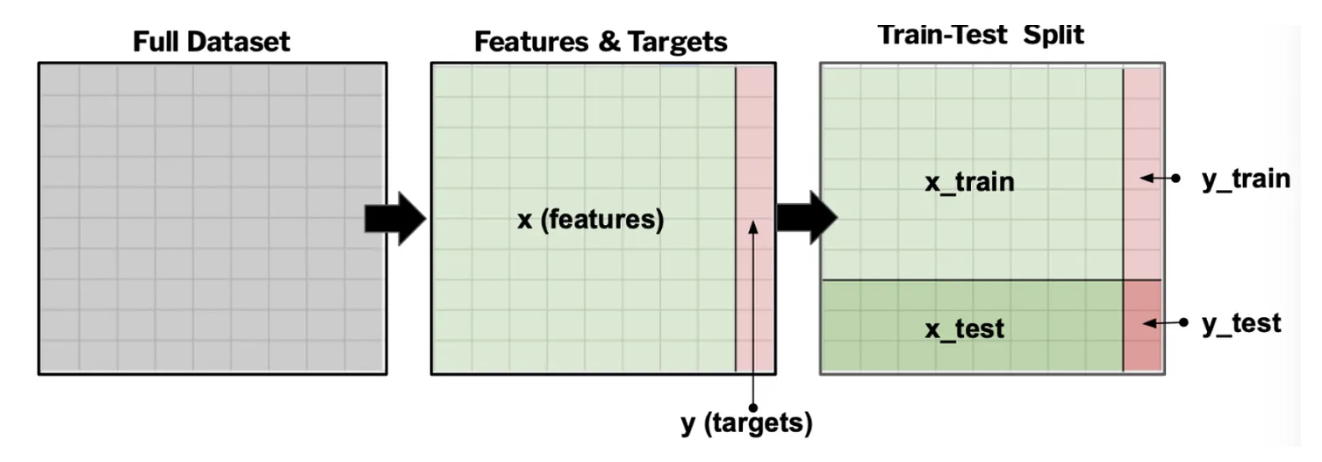

The main benefit of a train-test split is its fast and easy use. However, for it to be effective, you need a large dataset. Additionally, the dataset needs to be relatively homogenous such that both splits of the dataset are representative of the whole sample.

Now, lets’s look at a practical example using gene expression data. The code below creates a synthetic dataset for 1000 patients across 50 genes, with expression values in log2 scale ranging from 0 to 15. It then creates a simple disease classification rule: if the sum of expression values for gene_0 and gene_1 is greater than 20, the patient is classified as diseased.

Using this synthetic data, it trains a Random Forest classifier on 70% of the data while reserving 30% for testing. The stratification during splitting ensures that the proportion of healthy to diseased samples remains consistent between training and test sets. This mimics a real-world scenario where we might use gene expression signatures to develop a diagnostic test, though actual biological relationships would be far more complex.



In [6]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

# Generate synthetic gene expression data
np.random.seed(42)
n_samples, n_genes = 1000, 50

# Simulate expression levels between 0 and 15 (log2 scale common in RNA-seq)
gene_exp_data = pd.DataFrame(np.random.uniform(0, 15, size=(n_samples, n_genes)),columns=[f'gene_{i}' for i in range(n_genes)])

# Generate synthetic disease status (0: healthy, 1: diseased)
# Make it dependent on some gene expression patterns for realism
disease_status = (gene_exp_data['gene_0'] + gene_exp_data['gene_1'] > 20).astype(int)
gene_exp_data['disease_status'] = disease_status

# Separate features (gene expression levels) and target (disease status)
x, y = gene_exp_data.drop('disease_status', axis=1), gene_exp_data['disease_status']

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate
accuracy = model.score(X_test, y_test)
print(f'Model accuracy: {accuracy:.2f}')

Model accuracy: 0.91


Now, using the code above out model accuracy is 0.91, or 91%. However, if you play with the code a bit and change our model size you’ll notice a relationship between test size and model performance, illustrating a fundamental trade-off in machine learning. Specifically, as test size increases, performance worsens.

When you set a very high test size (e.g., 0.7 or 0.8), you're leaving fewer samples for training, which means your model has less data to learn from and thus builds a less robust understanding of the underlying patterns. Conversely, when you set a low test size (e.g., 0.1 or 0.2), you give your model more training data to learn from, typically resulting in better performance – but this comes with a catch: your performance estimate becomes less reliable since you're testing on fewer samples. As a result, I recommend sticking to the classic 70/30 train-test split, unless you have a good reason to deviate.

#🧬 K-Fold Cross-Validation: Robust Performance Estimation
While train-test split is useful, it can be sensitive to how we divide the data. In the biotech industry, where data collection is often expensive and time-consuming, making the most of limited data is crucial. K-fold cross-validation offers a more robust solution.

Think of k-fold cross-validation like running multiple experimental replicates. Instead of a single train-test split, we divide our data into k parts and perform k different evaluations, each time using a different portion as the test set. So, for example, if k=4, then you evaluate your model four times, and each time a different fold is used for testing while the other three are used to train your model, as demonstrated in the image below. This results in four performance scores, which can be averaged to determine how well your model performs.

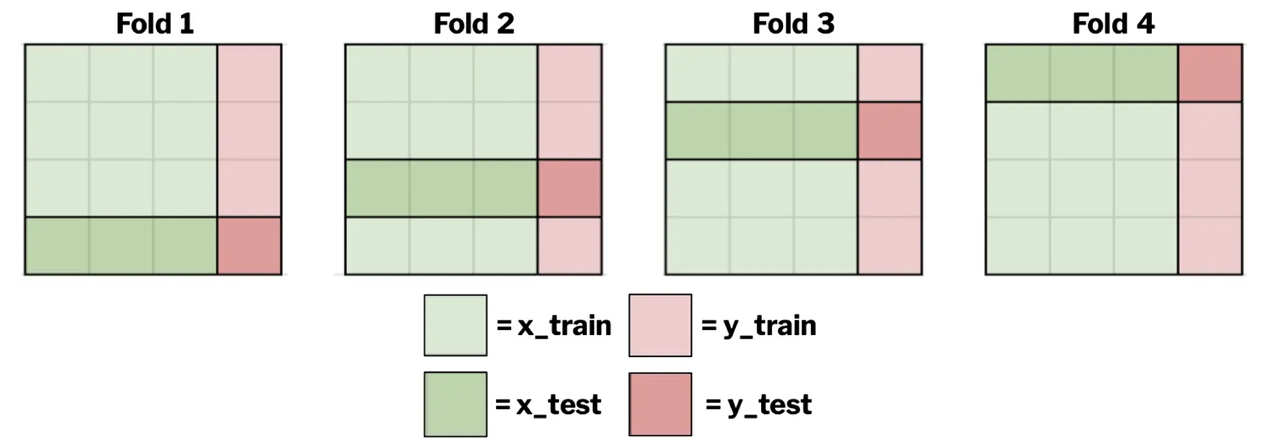Screenshot 2025-02-10 at 12 27 27 PM
K-fold cross-validation is particularly valuable when working with heterogeneous biological data, where a single split might not be representative.

When performing k-fold cross-validation, the most critical decision you'll have to make is how large your k is (i.e., how many splits or folds you create). For moderate-sized datasets (thousands or tens of thousands of rows), k-values of 5-10 are common, whereas k-values of 3-5 are more appropriate for smaller datasets. Here's an example using protein binding affinity data:

Mean R² score: 0.83 (±0.04)


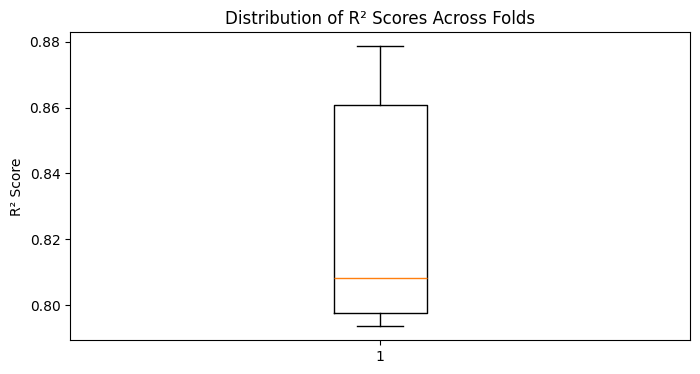

In [7]:
# Import libraries
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score

# Generate synthetic protein-ligand binding data
np.random.seed(42)
n_samples, n_features = 500, 10

# Create synthetic molecular descriptors (features)
X_synthetic = pd.DataFrame(np.random.normal(0, 1, size=(n_samples, n_features)),columns=[f'descriptor_{i}' for i in range(n_features)])

# Generate synthetic binding affinities
# Simulate -log(Kd) values typically ranging from 2 to 12
y_synthetic = 7 + 2 * X_synthetic['descriptor_0'] + \
              np.random.normal(0, 0.5, n_samples)
binding_data = X_synthetic.copy()
binding_data['binding_affinity'] = y_synthetic
X, y = binding_data.drop('binding_affinity', axis=1), binding_data['binding_affinity']

# Setup k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Create and evaluate model
model = SVR(kernel='rbf')
scores = cross_val_score(model, X, y, cv=kfold, scoring='r2')
print(f'Mean R² score: {scores.mean():.2f} (±{scores.std():.2f})')

# Visualize score distribution
plt.figure(figsize=(8, 4))
plt.boxplot(scores)
plt.title('Distribution of R² Scores Across Folds')
plt.ylabel('R² Score')
plt.show()

The code above demonstrates k-fold cross-validation using a realistic protein-ligand binding scenario, where we aim to predict binding affinities from molecular properties.

First, we begin by creating synthetic data that mimics a typical drug discovery dataset, including 500 computes characterized by 10 molecular descriptors and their corresponding binding affinities (-log(Kd) values) to a target protein. The binding affinity is primarily determined by the first molecular descriptor with some added noise, simulating how certain molecular features often dominate binding behavior. We then use a Support Vector Regression model to predict these binding affinities, evaluating its performance using 5-fold cross-validation and visualizing the R² scores across folds with a boxplot.

#🧬 Leave-One-Out Cross-Validation: Maximum Data Utilization

In some biotechnology applications, such as rare disease diagnosis or expensive assays, we might have very limited data. Leave-one-out cross-validation (LOOCV) is particularly valuable in these cases, as it makes the most efficient use of small datasets.

LOOCV takes k-fold cross-validation to its extreme, setting k equal to the number of samples. While computationally intensive, this approach is often worth the cost in biotech applications where data collection is the primary bottleneck. Below you’ll find code demonstrating LOOCV using a synthetic cell viability assay, where we simulate testing 5 different compounds across 200 experiments.

In [15]:
# import libraries
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score

# Generate synthetic cell viability data
np.random.seed(42)
n_samples, n_compounds = 200, 5

# Create synthetic compound properties
X_synthetic = pd.DataFrame(np.random.uniform(0, 1, size=(n_samples, n_compounds)),columns=[f'compound_{i}_concentration' for i in range(n_compounds)])

# Generate synthetic viability scores (0-100%)
# Create a non-linear relationship with compound concentrations
y_synthetic = 100 * np.exp(-2 * X_synthetic.mean(axis=1)) + \
              np.random.normal(0, 5, n_samples)
y_synthetic = np.clip(y_synthetic, 0, 100)  # Clip to valid range
viability_data = X_synthetic.copy()
viability_data['viability_score'] = y_synthetic
# Use x, y instead of X, y to extract features and target from viability_data
x, y = viability_data.drop('viability_score', axis=1), viability_data['viability_score']

# Setup and perform LOOCV
loocv = LeaveOneOut()
model = KNeighborsRegressor(n_neighbors=3)
# Use x instead of X in cross_val_score to match the correct features with target
scores = cross_val_score(model, x, y, cv=loocv, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)  # Convert MSE to RMSE
print(f'Mean RMSE: {rmse_scores.mean():.2f} (±{rmse_scores.std():.2f})')

Mean RMSE: 5.18 (±4.30)


The synthetic data in the example above mimics a typical dose-response relationship: cell viability decreases exponentially as the average compound concentration increases, with some random experimental noise added (note- we ensure viability stays between 0-100%).

The code uses a k-nearest neighbors regression model to predict cell viability from compound concentrations, evaluating its performance using LOOCV – meaning it trains on 199 experiments and tests on the remaining one, repeating this process 200 times. The performance is measured in RMSE (Root Mean Square Error), which tells us the typical prediction error in percentage points of viability.

#🧬 Choosing the Right Evaluation Method
Selecting the appropriate evaluation method for your needs requires careful consideration of several interrelated factors. The size of your dataset often serves as the primary guiding factor. When working with large datasets containing over 10,000 samples, such as high-throughput screening results or genomic data, both train-test splits and k-fold cross-validation can provide reliable results. For medium-sized datasets typical in protein structure studies or metabolomics, k-fold cross-validation tends to offer the best balance between computational efficiency and reliable performance estimation. In cases where data is particularly scarce, such as rare disease studies or expensive clinical trials with fewer than 1,000 samples, leave-one-out cross-validation becomes the method of choice despite its computational intensity.

The cost and effort of data collection should also influence your decision. For instance, when working with clinical trial data or patient-derived samples where each datapoint represents significant investment and ethical considerations, you'll want to extract maximum value through LOOCV or k-fold CV. Cell culture experiments and standard assays, while still requiring significant effort, often allow for more moderate approaches like k-fold CV. For computational predictions or in silico experiments where data generation is relatively inexpensive, a simple train-test split might suffice.

Available computational resources can further refine your choice. In resource-constrained environments or when working with complex models that take hours to train, a train-test split offers practical advantages. With access to moderate computing power, k-fold CV provides a sweet spot between computational cost and evaluation reliability. When abundant computational resources are available and dataset size permits, LOOCV can provide the most thorough evaluation.

#🧬 Best Practices for Biotechnology Applications
The unique characteristics of biological data demand careful attention to evaluation practices. A cornerstone principle is the use of truly independent test sets for final validation. This means setting aside a portion of your data that remains completely untouched throughout the model development process, including during hyperparameter tuning and cross-validation. This practice is particularly crucial in biotechnology, where models often need to generalize to entirely new biological contexts.

Biological data rarely comes in a simple, independent format. Whether you're working with related protein sequences, time-series gene expression data, or patient samples from different populations, the inherent structure of your data should inform your evaluation strategy. For instance, when working with protein families, ensure related sequences don't span across your training and validation sets. With time-series data, consider using time-based splits rather than random sampling to maintain temporal relationships.

The inherent variability in biological systems makes uncertainty quantification essential. Rather than reporting single performance numbers, always include measures of variation in your results. This might mean reporting standard deviations across cross-validation folds or confidence intervals for your performance metrics. This practice helps other researchers gauge the reliability and robustness of your models in the context of biological variation.

The choice of evaluation metrics should align closely with the biological questions you're addressing. Consider a drug discovery project: while overall accuracy matters, the cost of missing a potential drug candidate (false negative) might far outweigh the cost of investigating a false positive. In such cases, metrics like sensitivity or recall might be more relevant than pure accuracy. Similarly, in diagnostic applications, the balance between sensitivity and specificity should reflect the real-world implications of false positives versus false negatives in the specific medical context.

#🧬 Conclusion
Proper model evaluation is crucial in biotechnology applications, where decisions based on machine learning models can have significant implications for research directions and potential therapeutic developments. By understanding and appropriately applying these evaluation techniques, you can develop more reliable and robust models for your biological applications.

Remember that no evaluation method is perfect, and the best approach often combines multiple methods to gain a comprehensive understanding of your model's performance. Always consider the specific requirements and constraints of your biotechnology application when choosing evaluation strategies.